# Imports and installs

In this notebook, we generate and save the experimental data for all figures. This might take several days to run. Each figure's data can be generated independently by running the respective cells, and a given figure can be rendered without generating data for other figures.

This notebook is designed to be run in Google Colab, in which the path ```/content``` exists. To use this notebook outside of Colab, only self-evident changes to the Imports and Installs section should be necessary. This first cell isn't required if ```neural_tangents``` and ```eigenlearning``` are already installed.

In [ ]:
!pip install -q git+https://www.github.com/google/neural-tangents

import os
import sys

if os.path.isdir('/content/eigenlearning'):
  !rm -r '/content/eigenlearning'
!git clone -q https://github.com/james-simon/eigenlearning.git
sys.path.insert(0,'/content/eigenlearning')

In [ ]:
import json
import math

import jax.numpy as np
import jax.random as random

In [ ]:
from utils import get_net_fns, net_predictions
from measures import learning_measure_predictions, learning_measure_statistics, find_C
from unit_circle import unit_circle_eigenvalues, get_unit_circle_dataset
from hypercube import hypercube_eigenvalues
from hypersphere import hypersphere_eigenvalues

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
main_dir = '/content/drive/Shareddrives/Eigenlearning'

# Generate data for figures

## Illustrative toy problem plots

In [ ]:
for dir in [main_dir+'/A', main_dir+'/A/circle']:
  if not os.path.exists(dir):
      os.makedirs(dir)

In [ ]:
net_fns = get_net_fns(width=500, d_out=1, n_hidden_layers=4)

In [ ]:
M = 256
ks = [2, 7]

lambdas, mults = unit_circle_eigenvalues(net_fns[2], M), 1

In [ ]:
exp_params = {
    'domain': 'circle',
    'M': M,
    'n': None,
    'f_terms': None,
    'g_terms':None,
    'n_epochs': 10000,
    'lr': .5,
    'stop_mse': 10**-7,
    'print_every': None,
    'n_trials': 30,
    'lambdas': lambdas,
    'mults': mults,
    'seed': 2,
    'pred_type': 'both'
}

### Unit Circle - example runs

In [ ]:
ns = [2**2, 2**4, 2**6]

subkey = np.array([0,2],dtype='uint32')
index_bank = random.choice(subkey, np.arange(0, M, 1), shape=[M], replace=False)

interpolation_plot_datasets = {}
for k in ks:
  (test_thetas, test_X, test_y) = get_unit_circle_dataset(M, [{(k,'c') : 2**(-.5)}])
  test_y = test_y[0]
  for n in ns:
    interpolation_plot_datasets[(k,n)] = [(test_thetas[index_bank[:n]], test_X[index_bank[:n]], test_y[index_bank[:n]]), (test_thetas, test_X, test_y)]

In [ ]:
results_int = {'datasets':{}, 'y_hats':{}}

for k in ks:
  for n in ns:
    (train_thetas, train_X, train_y), (test_thetas, test_X, test_y) = interpolation_plot_datasets[(k,n)]
    net_preds = net_predictions(net_fns, ((train_X, train_y),(test_X,test_y)), exp_params['n_epochs'], exp_params['lr'], subkey, stop_mse=exp_params['stop_mse'])

    results_int['datasets'][str(k) + ',' + str(n)] = [[vals.tolist() for vals in valset] for valset in interpolation_plot_datasets[(k,n)]]
    results_int['y_hats'][str(k) + ',' + str(n)] = net_preds['test_preds'].tolist()

    with open(main_dir+'/A/circle/results_int.json', 'w') as file:
      json.dump(results_int, file)

### Unit Circle - experiments

In [ ]:
g_terms = [{(5,'c') : 1}]
exp_params['g_terms'] = g_terms

ns_exp = [0] + [2**i for i in range(round(math.log2(M)) + 1)]
ns_th = list(np.linspace(0, 1, 10, endpoint=False)) + list(np.logspace(0, math.log10(M), 50))

##### Unit circle theory

In [ ]:
results_th = {}

for n in ns_th:
  for k in ks:
    exp_params['f_terms'] = {(k, 'c') : 2**(-.5)}
    exp_params['n'] = n
    results = learning_measure_predictions(net_fns[2], **exp_params)
    results['g_coeffs'][0] = list(results['g_coeffs'][0])
    results['g_coeffs'][0][1] = results['g_coeffs'][0][1].real  # squelch a little imaginary numerical error
    results_th[str(k) + ',' + '%.3f'%n] = results
    with open(main_dir+'/A/circle/results_th.json', 'w') as file:
      json.dump(results_th, file)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


##### Unit circle experiment

In [ ]:
results_exp = {}

for n in ns_exp:
  for k in ks:
    print(f'predicting for {(k, n)}')
    exp_params['f_terms'] = {(k, 'c') : 2**(-.5)}
    exp_params['n'] = n
    results = learning_measure_statistics(net_fns, **exp_params)
    results_exp[str(k) + ',' + str(n)] = results
    with open(main_dir+'/A/circle/results_exp.json', 'w') as file:
      json.dump(results_exp, file)
  print()

## Learnability curves

In [ ]:
for dir in [main_dir+'/B', main_dir+'/B/circle', main_dir+'/B/hypercube', main_dir+'/B/hypersphere']:
  if not os.path.exists(dir):
      os.makedirs(dir)

In [ ]:
net_fns = get_net_fns(width=500, d_out=1, n_hidden_layers=4)

### Unit Circle

In [ ]:
M = 2**8

ks = [0, 2, 5, 10]

ns_exp = [0] + [2**i for i in range(round(math.log2(M)) + 1)]
ns_th = list(np.linspace(0, 1, 10, endpoint=False)) + list(np.logspace(0, math.log10(M), 50))

lambdas, mults = unit_circle_eigenvalues(net_fns[2], M), 1

In [ ]:
exp_params = {
    'domain': 'circle',
    'M': M,
    'n': None,
    'f_terms': None,
    'g_terms': [],
    'n_epochs': 10000,
    'lr': .5,
    'stop_mse': 10**-5,
    'print_every': None,
    'n_trials': 30,
    'lambdas': lambdas,
    'mults': mults,
    'seed': 1,
    'pred_type': 'both'
}

##### Unit circle theory

In [ ]:
results_th = {}

for n in ns_th:
  # print(f'predicting for n = {n}')
  for k in ks:
    exp_params['f_terms'] = {(k, 'c') : 1}
    exp_params['n'] = n
    results = learning_measure_predictions(net_fns[2], **exp_params)
    results_th[str(k) + ',' + '%.3f'%n] = results
    with open(main_dir+'/B/circle/results_th.json', 'w') as file:
      json.dump(results_th, file)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


##### Unit circle experiment

In [ ]:
results_exp = {}

for n in ns_exp:
  for k in ks:
    print(f'predicting for {(k, n)}')
    exp_params['f_terms'] = {(k, 'c') : 1}
    exp_params['n'] = n
    results = learning_measure_statistics(net_fns, **exp_params)
    results_exp[str(k) + ',' + str(n)] = results
    with open(main_dir+'/B/circle/results_exp.json', 'w') as file:
      json.dump(results_exp, file)
  print()

### Hypercube

In [ ]:
d = 8

ks = [0, 1, 3, 8]

ns_exp = [0] + [2**i for i in range(d + 1)]
ns_th = list(np.linspace(0, 1, 10, endpoint=False)) + list(np.logspace(0, math.log10(2**d), 50))

lambdas, mults = hypercube_eigenvalues(net_fns[2], d)

In [ ]:
exp_params = {
    'domain': 'hypercube',
    'd': d,
    'n': None,
    'f_terms': None,
    'g_terms': [],
    'n_epochs': 10000,
    'lr': .5,
    'stop_mse': 10**-5,
    'print_every': None,
    'n_trials': 30,
    'lambdas': lambdas,
    'mults': mults,
    'seed': 1,
    'pred_type': 'both'
}

##### Hypercube theory

In [ ]:
results_th = {}

for n in ns_th:
  for k in ks:
    # print(f'predicting for n = {n}')
    exp_params['f_terms'] = {k : 1}
    exp_params['n'] = n
    results = learning_measure_predictions(net_fns[2], **exp_params)
    results_th[str(k) + ',' + '%.3f'%n] = results
    with open(main_dir+'/B/hypercube/results_th.json', 'w') as file:
      json.dump(results_th, file)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


##### Hypercube experiment

In [ ]:
results_exp = {}

for n in ns_exp:
  for k in ks:
    print(f'predicting for {(k, n)}')
    exp_params['f_terms'] = {k : 1}
    exp_params['n'] = n
    results = learning_measure_statistics(net_fns, **exp_params)
    results_exp[str(k) + ',' + str(n)] = results
    with open(main_dir+'/B/hypercube/results_exp.json', 'w') as file:
      json.dump(results_exp, file)
  print()

### Hypersphere

In [ ]:
d = 8
n_max = 2**8

ks = [0, 1, 2, 3, 4, 5]

ns_exp = [0] + [2**i for i in range(round(math.log2(n_max)) + 1)]
ns_th = list(np.linspace(0, 1, 10, endpoint=False)) + list(np.logspace(0, math.log10(n_max), 50))

lambdas, mults = hypersphere_eigenvalues(net_fns[2], d)

In [ ]:
exp_params = {
    'domain': 'hypersphere',
    'd': d,
    'n': None,
    'n_test': 10**4,
    'f_terms': None,
    'g_terms': [],
    'n_epochs': 10000,
    'lr': .5,
    'stop_mse': 10**-5,
    'print_every': None,
    'n_trials': 30,
    'lambdas': lambdas,
    'mults': mults,
    'seed': 1,
    'pred_type': 'both'
}

##### Hypersphere theory

In [ ]:
results_th = {}

for n in ns_th:
  # print(f'predicting for n = {n}')
  for k in ks:
    exp_params['f_terms'] = {k : 1}
    exp_params['n'] = n
    results = learning_measure_predictions(net_fns[2], **exp_params)
    results_th[str(k) + ',' + '%.3f'%n] = results
    with open(main_dir+'/B/hypersphere/results_th.json', 'w') as file:
      json.dump(results_th, file)

##### Hypersphere experiment

In [ ]:
results_exp = {}

for n in ns_exp:
  for k in ks:
    print(f'predicting for {(k, n)}')
    exp_params['f_terms'] = {k : 1}
    exp_params['n'] = n
    results = learning_measure_statistics(net_fns, **exp_params)
    results_exp[str(k) + ',' + str(n)] = results
    with open(main_dir+'/B/hypersphere/results_exp.json', 'w') as file:
      json.dump(results_exp, file)
  print()

## Universal sigmoidal learnability curves

In [ ]:
for dir in [main_dir+'/C', main_dir+'/C/circle', main_dir+'/C/hypercube', main_dir+'/C/hypersphere']:
  if not os.path.exists(dir):
      os.makedirs(dir)

In [ ]:
net_fns = get_net_fns(width=500, d_out=1, n_hidden_layers=4)

### Unit Circle

In [ ]:
M = 2**8

ks = [0, 1, 2, 3, 4, 5, 6, 7]

ns_exp = [2**3, 2**6]

lambdas, mults = unit_circle_eigenvalues(net_fns[2], M), 1

In [ ]:
exp_params = {
    'domain': 'circle',
    'M': M,
    'n': None,
    'f_terms': None,
    'g_terms': [],
    'n_epochs': 10000,
    'lr': .5,
    'stop_mse': 10**-5,
    'print_every': None,
    'n_trials': 30,
    'lambdas': lambdas,
    'mults': mults,
    'seed': 1,
    'pred_type': 'both'
}

##### Unit circle experiment

In [ ]:
results_exp = {}

for n in ns_exp:
  for k in ks:
    print(f'predicting for {(k, n)}')
    exp_params['f_terms'] = {(k, 'c') : 1}
    exp_params['n'] = n
    results = learning_measure_statistics(net_fns, **exp_params)
    results_exp[str(k) + ',' + str(n)] = results
    with open(main_dir+'/C/circle/results_exp.json', 'w') as file:
      json.dump(results_exp, file)
  print()

##### Unit circle theory

In [ ]:
Cs = {n : find_C(n, lambdas, mults).item() for n in ns_exp}

results_th = {
    'lambdas' : [float(l) for l in lambdas],
    'Cs' : Cs
}

with open(main_dir+'/C/circle/results_th.json', 'w') as file:
  json.dump(results_th, file)

### Hypercube

In [ ]:
d = 8

ks = [0, 1, 2, 3, 4, 5, 6]

ns_exp = [2**3, 2**6]

lambdas, mults = hypercube_eigenvalues(net_fns[2], d)

In [ ]:
exp_params = {
    'domain': 'hypercube',
    'd': d,
    'n': None,
    'f_terms': None,
    'g_terms': [],
    'n_epochs': 10000,
    'lr': .1,
    'stop_mse': 10**-5,
    'print_every': None,
    'n_trials': 30,
    'lambdas': lambdas,
    'mults': mults,
    'seed': 1,
    'pred_type': 'both'
}

##### Hypercube experiment

In [ ]:
results_exp = {}

for n in ns_exp:
  for k in ks:
    print(f'predicting for {(k, n)}')
    exp_params['f_terms'] = {k : 1}
    exp_params['n'] = n
    results = learning_measure_statistics(net_fns, **exp_params)
    results_exp[str(k) + ',' + str(n)] = results
    with open(main_dir+'/C/hypercube/results_exp.json', 'w') as file:
      json.dump(results_exp, file)
  print()

##### Hypercube theory

In [ ]:
Cs = {n : find_C(n, lambdas, mults).item() for n in ns_exp}

results_th = {
    'lambdas' : [float(l) for l in lambdas],
    'Cs' : Cs
}

with open(main_dir+'/C/hypercube/results_th.json', 'w') as file:
  json.dump(results_th, file)

### Hypersphere

In [ ]:
d = 8

ks = [0, 1, 2, 3, 4, 5, 6, 7]

ns_exp = [2**3, 2**6]

lambdas, mults = hypersphere_eigenvalues(net_fns[2], d)

In [ ]:
exp_params = {
    'domain': 'hypersphere',
    'd': d,
    'n': None,
    'n_test': 10**4,
    'f_terms': None,
    'g_terms': [],
    'n_epochs': 10000,
    'lr': .5,
    'stop_mse': 10**-5,
    'print_every': None,
    'n_trials': 30,
    'lambdas': lambdas,
    'mults': mults,
    'seed': 1,
    'pred_type': 'both'
}

##### Hypersphere experiment

In [ ]:
results_exp = {}

for n in ns_exp:
  for k in ks:
    print(f'predicting for {(k, n)}')
    exp_params['f_terms'] = {k : 1}
    exp_params['n'] = n
    results = learning_measure_statistics(net_fns, **exp_params)
    results_exp[str(k) + ',' + str(n)] = results
    with open(main_dir+'/C/hypersphere/results_exp.json', 'w') as file:
      json.dump(results_exp, file)
  print()

##### Hypersphere theory

In [ ]:
Cs = {n : find_C(n, lambdas, mults).item() for n in ns_exp}

results_th = {
    'lambdas' : [float(l) for l in lambdas],
    'Cs' : Cs
}

with open(main_dir+'/C/hypersphere/results_th.json', 'w') as file:
  json.dump(results_th, file)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


## Nonmonotonic MSE curves

In [ ]:
for dir in [main_dir+'/D', main_dir+'/D/circle', main_dir+'/D/hypercube', main_dir+'/D/hypersphere']:
  if not os.path.exists(dir):
      os.makedirs(dir)

In [ ]:
net_fns = get_net_fns(width=500, d_out=1, n_hidden_layers=4)

### Unit Circle

In [ ]:
M = 256

ks = [0, 2, 4, 6]

ns_exp = [0, 1, 2, 3, 4, 5, 6, 7]
ns_th = list(np.linspace(0, max(ns_exp), 50, endpoint=True))

lambdas, mults = unit_circle_eigenvalues(net_fns[2], M), 1

In [ ]:
exp_params = {
    'domain': 'circle',
    'M': M,
    'n': None,
    'f_terms': None,
    'g_terms': [],
    'n_epochs': 10000,
    'lr': .5,
    'stop_mse': 10**-5,
    'print_every': None,
    'n_trials': 100,
    'lambdas': lambdas,
    'mults': mults,
    'seed': 2,
    'pred_type': 'both'
}

##### Unit circle theory

In [ ]:
results_th = {}

l_sum = (lambdas*mults).sum().item()
l2_sum = (lambdas**2 * mults).sum().item()
dE_dn_preds = (l2_sum / l_sum**2 - 2 * lambdas / l_sum)
results_th['dE_dn'] = [float(x) for x in dE_dn_preds]

for n in ns_th:
  # print(f'predicting for n = {n}')
  for k in ks:
    exp_params['f_terms'] = {(k,'c') : 1}
    exp_params['n'] = n
    results = learning_measure_predictions(net_fns[2], **exp_params)
    results_th[str(k) + ',' + '%.3f'%n] = results
    with open(main_dir+'/D/circle/results_th.json', 'w') as file:
      json.dump(results_th, file)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


##### Unit circle experiment

In [ ]:
results_exp = {}

for n in ns_exp:
  for k in ks:
    print(f'predicting for {(k, n)}')
    exp_params['f_terms'] = {(k,'c') : 1}
    exp_params['n'] = n
    results = learning_measure_statistics(net_fns, **exp_params)
    results_exp[str(k) + ',' + str(n)] = results
    with open(main_dir+'/D/circle/results_exp.json', 'w') as file:
      json.dump(results_exp, file)
  print()

### Hypercube

In [ ]:
d = 6

ks = [0, 2, 4, 6]

ns_exp = [0, 1, 2, 3, 4, 5, 6, 7]
ns_th = list(np.linspace(0, max(ns_exp), 50, endpoint=True))

lambdas, mults = hypercube_eigenvalues(net_fns[2], d)

In [ ]:
exp_params = {
    'domain': 'hypercube',
    'd': d,
    'n': None,
    'f_terms': None,
    'g_terms': [],
    'n_epochs': 10000,
    'lr': .1,
    'stop_mse': 10**-5,
    'print_every': None,
    'n_trials': 100,
    'lambdas': lambdas,
    'mults': mults,
    'seed': 2,
    'pred_type': 'both'
}

##### Hypercube theory

In [ ]:
results_th = {}

l_sum = (lambdas*mults).sum().item()
l2_sum = (lambdas**2 * mults).sum().item()
dE_dn_preds = (l2_sum / l_sum**2 - 2 * lambdas / l_sum)
results_th['dE_dn'] = [float(x) for x in dE_dn_preds]

for n in ns_th:
  # print(f'predicting for n = {n}')
  for k in ks:
    exp_params['f_terms'] = {k : 1}
    exp_params['n'] = n
    results = learning_measure_predictions(net_fns[2], **exp_params)
    results_th[str(k) + ',' + '%.3f'%n] = results
    with open(main_dir+'/D/hypercube/results_th.json', 'w') as file:
      json.dump(results_th, file)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


##### Hypercube experiment

In [ ]:
results_exp = {}

for n in ns_exp:
  for k in ks:
    print(f'predicting for {(k, n)}')
    exp_params['f_terms'] = {k : 1}
    exp_params['n'] = n
    results = learning_measure_statistics(net_fns, **exp_params)
    results_exp[str(k) + ',' + str(n)] = results
    with open(main_dir+'/D/hypercube/results_exp.json', 'w') as file:
      json.dump(results_exp, file)
  print()

### Hypersphere

In [ ]:
d = 3

ks = [0, 2, 4, 6, 8]

ns_exp = [0, 1, 2, 3, 4, 5, 6, 7]
ns_th = list(np.linspace(0, max(ns_exp), 50, endpoint=True))

lambdas, mults = hypersphere_eigenvalues(net_fns[2], d)

In [ ]:
exp_params = {
    'domain': 'hypersphere',
    'd': d,
    'n': None,
    'n_test': 10**5,
    'f_terms': None,
    'g_terms': [],
    'n_epochs': 10000,
    'lr': .1,
    'stop_mse': 10**-5,
    'print_every': None,
    'n_trials': 100,
    'lambdas': lambdas,
    'mults': mults,
    'seed': 2,
    'pred_type': 'both'
}

##### Hypersphere theory

In [ ]:
results_th = {}

l_sum = (lambdas*mults).sum().item()
l2_sum = (lambdas**2 * mults).sum().item()
dE_dn_preds = (l2_sum / l_sum**2 - 2 * lambdas / l_sum)
results_th['dE_dn'] = [float(x) for x in dE_dn_preds]

for n in ns_th:
  # print(f'predicting for n = {n}')
  for k in ks:
    exp_params['f_terms'] = {k : 1}
    exp_params['n'] = n
    results = learning_measure_predictions(net_fns[2], **exp_params)
    results_th[str(k) + ',' + '%.3f'%n] = results
    with open(main_dir+'/D/hypersphere/results_th.json', 'w') as file:
      json.dump(results_th, file)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


##### Hypersphere experiment

In [ ]:
results_exp = {}

for n in ns_exp:
  for k in ks:
    print(f'predicting for {(k, n)}')
    exp_params['f_terms'] = {k : 1}
    exp_params['n'] = n
    results = learning_measure_statistics(net_fns, **exp_params)
    results_exp[str(k) + ',' + str(n)] = results
    with open(main_dir+'/D/hypersphere/results_exp.json', 'w') as file:
      json.dump(results_exp, file)
  print()

## Testing the "no-free-lunch" theorem

In [ ]:
for dir in [main_dir+'/E', main_dir+'/E/circle']:
  if not os.path.exists(dir):
      os.makedirs(dir)

In [ ]:
net_fn_sets = []
net_fn_sets += [get_net_fns(width=500, d_out=1, n_hidden_layers=1)]
net_fn_sets += [get_net_fns(width=500, d_out=1, n_hidden_layers=4)]
net_fn_sets += [get_net_fns(width=500, d_out=1, n_hidden_layers=1, phi=np.tanh, W_std=1.5, b_std=.1)]
net_fn_sets += [get_net_fns(width=500, d_out=1, n_hidden_layers=4, phi=np.tanh, W_std=1.5, b_std=.1)]

In [ ]:
M = 10
ns_exp = [3, 6]
modes = [(k,'c') for k in range(M//2 + 1)] + [(k,'s') for k in range(1, (M+1)//2)]
print(modes)

[(0, 'c'), (1, 'c'), (2, 'c'), (3, 'c'), (4, 'c'), (5, 'c'), (1, 's'), (2, 's'), (3, 's'), (4, 's')]


In [ ]:
exp_params = {
    'domain': 'circle',
    'M': M,
    'n': None,
    'f_terms': None,
    'g_terms': [],
    'n_epochs': 10000,
    'lr': .5,
    'stop_mse': 10**-5,
    'print_every': None,
    'n_trials': 1,
    'seed': 1,
    'pred_type': 'both'
}

In [ ]:
assert main_dir[-1] == 'E'

results_exp = {}

for a, net_fns in enumerate(net_fn_sets):
  for n in ns_exp:
    print(f'testing (a={a}, n={n})')
    exp_params['n'] = n

    for mode in modes:
      exp_params['f_terms'] = {mode : 1}
      results_exp[str(a)+','+str(n)+','+str(mode[0])+','+str(mode[1])] = learning_measure_statistics(net_fns, **exp_params)
    
    with open(main_dir+'/E/circle/results_exp.json', 'w') as file:
      json.dump(results_exp, file)
  print()

testing (a=0, n=3)
testing (a=0, n=6)

testing (a=1, n=3)
testing (a=1, n=6)

testing (a=2, n=3)
testing (a=2, n=6)

testing (a=3, n=3)
testing (a=3, n=6)



## Repeating the hypercube experiment at various widths

In [ ]:
for dir in [main_dir, main_dir+'/F/hypercube']:
  if not os.path.exists(dir):
      os.makedirs(dir)

In [ ]:
widths = [500, 200, 100, 50, 20, 10]
net_fn_sets = {w : get_net_fns(width=w, d_out=1, n_hidden_layers=4) for w in widths}

### Hypercube

In [ ]:
d = 8

ks = [0, 1, 3, 8]

ns_exp = [0] + [2**i for i in range(d + 1)]
ns_th = list(np.linspace(0, 1, 10, endpoint=False)) + list(np.logspace(0, math.log10(2**d), 50))

lambdas, mults = hypercube_eigenvalues(net_fn_sets[widths[0]][2], d)

In [ ]:
exp_params = {
    'domain': 'hypercube',
    'd': d,
    'n': None,
    'f_terms': None,
    'g_terms': [],
    'n_epochs': 5000,
    'lr': .1,
    'stop_mse': 10**-3,
    'print_every': None,
    'n_trials': 30,
    'lambdas': lambdas,
    'mults': mults,
    'seed': 1,
    'pred_type': 'both'
}

##### Hypercube theory

In [ ]:
results_th = {}

for n in ns_th:
  for k in ks:
    # print(f'predicting for n = {n}')
    exp_params['f_terms'] = {k : 1}
    exp_params['n'] = n
    results = learning_measure_predictions(net_fn_sets[widths[0]][2], **exp_params)
    results_th[str(k) + ',' + '%.3f'%n] = results
    with open(main_dir+'/F/hypercube/results_th.json', 'w') as file:
      json.dump(results_th, file)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


##### Hypercube experiment

In [ ]:
for w in widths:
  results_exp = {}
  for n in ns_exp:
    print(f'predicting for {(w, n)}')
    for k in ks:
      exp_params['f_terms'] = {k : 1}
      exp_params['n'] = n
      results = learning_measure_statistics(net_fn_sets[w], **exp_params)
      results_exp[str(w) + ',' + str(k) + ',' + str(n)] = results
      with open(main_dir+f'/F/hypercube/results_exp_w{w}.json', 'w') as file:
        json.dump(results_exp, file)
    # print()

## Generating domain eigenvalues

In [ ]:
for dir in [main_dir+'/G']:
  if not os.path.exists(dir):
      os.makedirs(dir)

In [ ]:
net_fns = get_net_fns(width=500, d_out=1, n_hidden_layers=4)

In [ ]:
M = 256
lambdas_c, mults_c = unit_circle_eigenvalues(net_fns[2], M), np.ones(M)

d = 8
lambdas_h, mults_h = hypercube_eigenvalues(net_fns[2], d)

d = 8
lambdas_s, mults_s = hypersphere_eigenvalues(net_fns[2], d, k_max=70)

In [ ]:
eigenvalues = {
    'circle' : [lambdas_c.tolist(), mults_c.tolist()],
    'hypercube' : [lambdas_h.tolist(), mults_h.tolist()],
    'hypersphere' : [lambdas_s.tolist(), mults_s.tolist()]
}

In [ ]:
with open(main_dir+'/G/eigenvalues.json', 'w') as file:
  json.dump(eigenvalues, file)

## Examining statistics of $C^{(\Phi, \phi)}$

In [ ]:
for dir in [main_dir+'/H']:
  if not os.path.exists(dir):
      os.makedirs(dir)

In [ ]:
net_fns = get_net_fns(width=500, d_out=1, n_hidden_layers=4)

d = 8
lambdas_s, mults_s = hypersphere_eigenvalues(net_fns[2], d, k_max=70)

lambdas = []
for i in range(7):
  lambdas += [lambdas_s[i]]*int(mults_s[i])
lambdas = np.array(lambdas)

In [ ]:
def random_C(n, lambdas):
  global key
  key, subkey1, subkey2 = random.split(key, 3)
  Phi = random.normal(subkey1, (len(lambdas), n))
  phi = random.normal(subkey2, (n, 1))
  Lambda = np.diag(lambdas)
  C = 1/(phi.T @ np.linalg.inv(Phi.T @ Lambda @ Phi) @ phi)
  return C[1,1]

In [ ]:
def C_stats(n, lambdas, S=10**3):
  Cs = np.array([random_C(n, lambdas) for _ in range(S)])
  return Cs.mean(), Cs.var()

In [ ]:
key = random.PRNGKey(17)

In [ ]:
# M = 2**11
# lambdas = np.array([1/(1 + k**2) for k in range(M)])
S = 10**3
ns = [2**i for i in range(10)]

In [ ]:
ratios = [(lambda m,v : v/m**2)(*C_stats(n, lambdas, S)).item() for n in ns]

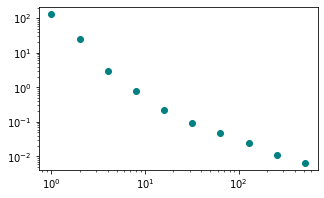

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5,3))
ax.set_xscale('log')
ax.set_yscale('log')

ax.scatter(ns, ratios, color=(0,.5,.5))

In [ ]:
with open(main_dir+'/H/ratios.json', 'w') as file:
  json.dump({'ns':ns, 'ratios':ratios}, file)